In [1]:
from datasets import load_dataset
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import soundfile as sf
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
tags_df = pd.read_csv("annotations_final.csv", sep='\t')

In [38]:
for col in tags_df.columns:
    print(col)

clip_id
no voice
singer
duet
plucking
hard rock
world
bongos
harpsichord
female singing
clasical
sitar
chorus
female opera
male vocal
vocals
clarinet
heavy
silence
beats
men
woodwind
funky
no strings
chimes
foreign
no piano
horns
classical
female
no voices
soft rock
eerie
spacey
jazz
guitar
quiet
no beat
banjo
electric
solo
violins
folk
female voice
wind
happy
ambient
new age
synth
funk
no singing
middle eastern
trumpet
percussion
drum
airy
voice
repetitive
birds
space
strings
bass
harpsicord
medieval
male voice
girl
keyboard
acoustic
loud
classic
string
drums
electronic
not classical
chanting
no violin
not rock
no guitar
organ
no vocal
talking
choral
weird
opera
soprano
fast
acoustic guitar
electric guitar
male singer
man singing
classical guitar
country
violin
electro
reggae
tribal
dark
male opera
no vocals
irish
electronica
horn
operatic
arabic
lol
low
instrumental
trance
chant
strange
drone
synthesizer
heavy metal
modern
disco
bells
man
deep
fast beat
industrial
hard
harp
no flute


In [53]:
classical_df = tags_df[tags_df['piano solo'] == 1]

In [54]:
classical_df

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
410,914,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6/gerard_satamian-dry_fig_trees-01-chansons_sa...
1097,2455,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/ehren_starks-lines_build_walls-01-lines_buil...
2066,4530,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d/seth_and_maryse_carlin-schubert__music_for_f...
3184,6963,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,e/justin_bianco-forge-02-dragonfly_in_amber_10...
4332,9408,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7/rob_costlow-woods_of_chaos-02-reflections-0-...
4547,9918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d/seth_and_maryse_carlin-schubert__music_for_f...
4557,9938,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4/seth_carlin-schubert__works_for_solo_fortepi...
6496,14131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/janine_johnson-chopin_recital-03-nocturne_op...
6667,14474,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d/daniel_ben_pienaar-book_2_cd1_welltempered_c...
7723,16941,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6/gerard_satamian-dry_fig_trees-04-chansons_sa...


In [5]:
def mp3_to_mel(path, sr=22050, n_mels=64, duration=10.0):

    try:        
        y, _ = librosa.load("mp3_full/" + tags_df.iloc[0]['mp3_path'], sr=22050, duration=10.0)
        y = y / np.max(np.abs(y))  
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, hop_length=512, n_fft=2048)
        S_dB = librosa.power_to_db(S, ref=np.max)
        return S_dB
    except:
        return None

In [6]:
test = mp3_to_mel(classical_df.iloc[3]['mp3_path'])

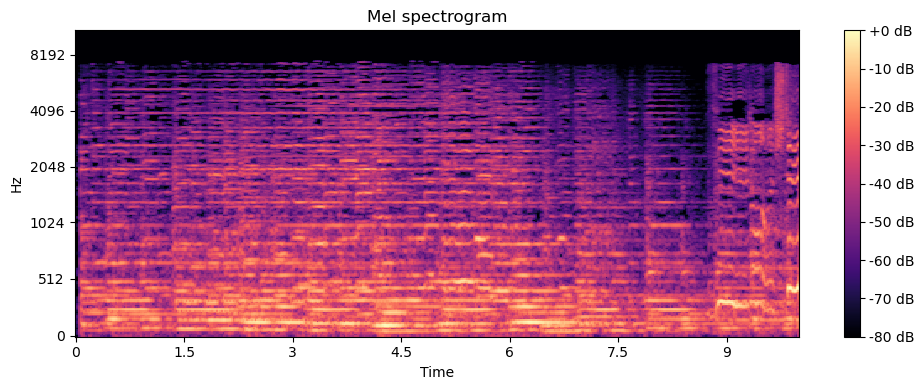

In [7]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(test, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [8]:
mel_specs = []

for i, row in tqdm(classical_df.iterrows(), total=len(classical_df)):
    mel = mp3_to_mel(row["mp3_path"])
    if mel is not None:
        mel_specs.append(mel)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 4272/4272 [01:24<00:00, 50.82it/s]


In [28]:
Y = np.stack([s.T for s in mel_specs])

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# ==== Dataset ====

class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms):
        # spectrograms: numpy array of shape (N, H, W), already normalized to [0,1]
        self.spectrograms = spectrograms
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spec = self.spectrograms[idx].astype(np.float32)
        spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-8)
        spec = torch.tensor(spec).unsqueeze(0)  # (1, 431, 256)
        return spec

# ==== VAE Model ====

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # (32, 216, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),                              # (64, 108, 64)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),                             # (128, 54, 32)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),                            # (256, 27, 16)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 27 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 27 * 16, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 256 * 27 * 16)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (128, 54, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (64, 108, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (32, 216, 128)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),     # (1, 432, 256) — may be one extra row
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 256, 16, 16)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ==== Loss function ====

def vae_loss(recon_x, x, mu, logvar):
    # Use mean over batch to keep loss scale stable
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_loss

# ==== Save and Load raw data functions ====

def save_spectrograms(spectrograms, filename='spectrograms.npy'):
    np.save(filename, spectrograms)

def load_spectrograms(filename='spectrograms.npy'):
    return np.load(filename)

# ==== Training loop ====

def train_vae(vae, dataloader, epochs=20, device='cpu'):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    vae.to(device)
    
    for epoch in tqdm(range(epochs)):
        vae.train()
        total_loss = 0
        # for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Avg loss: {avg_loss:.4f}")

# ==== Example usage ====

# if __name__ == "__main__":
# Assume your raw spectrograms are in a numpy array of shape (4272, 431, 256)
# raw_specs = np.load('your_raw_spectrograms.npy')  # load your dataset
raw_specs = Y

# Normalize globally
global_min = raw_specs.min()
global_max = raw_specs.max()
specs_norm = (raw_specs - global_min) / (global_max - global_min + 1e-8)

# Save normalized data for later (optional)
# save_spectrograms(specs_norm, 'spectrograms_norm.npy')

# Load normalized data and create Dataset + DataLoader
# specs = load_spectrograms('spectrograms_norm.npy')
dataset = SpectrogramDataset(specs_norm)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate model and train
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(latent_dim=32)
train_vae(vae_model, dataloader, epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu')

  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x106496 and 65536x32)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# 1. Sample a latent vector
with torch.no_grad():
    z = torch.randn(1, model.latent_dim).to(device)
    
    # 2. Decode to normalized spectrogram
    generated_spec = model.decode(z)  # shape: (1, 1, 256, 256)
    generated_spec = generated_spec.squeeze().cpu().numpy()  # shape: (256, 256)

# 3. Undo normalization (use same global min/max from training)
S_dB_generated = generated_spec * (global_max - global_min) + global_min

# 4. Convert dB back to power
S_generated_power = librosa.db_to_power(S_dB_generated)

# 5. Convert Mel spectrogram to waveform
audio = librosa.feature.inverse.mel_to_audio(
    S_generated_power,
    sr=22050,
    hop_length=512,
    n_fft=2048,
    n_iter=100
)

# 6. Play the audio
Audio(audio, rate=22050)

In [25]:
model.eval()

with torch.no_grad():
    z = torch.randn(1, model.latent_dim).to(device)  # sample from standard normal
    generated_spec = model.decode(z)  # shape: (1, 1, 256, 256)
    generated_spec = generated_spec.squeeze().cpu().numpy()  # shape: (256, 256)

S_dB_generated = generated_spec * (global_max - global_min) + global_min

S_generated_power = librosa.db_to_power(S_dB_generated)

audio = librosa.feature.inverse.mel_to_audio(
    S_generated_power,
    sr=22050,
    hop_length=512,
    n_fft=2048,
    n_iter=100
)

Audio(audio, rate=22050)

In [62]:
series = tags_subset.iloc[53].drop(['mp3_path', 'clip_id'])

In [63]:
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(series, dtype=torch.float32).unsqueeze(0)  # add batch dim
    pred_spec = model(input_tensor)  # output shape should match your spectrogram shape flattened
    pred_spec = pred_spec.view(431, 256) 

/var/folders/7p/wg0zk8v57znc3kpkhyrykp740000gn/T/ipykernel_88146/1099328404.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_tensor = torch.tensor(series, dtype=torch.float32).unsqueeze(0)  # add batch dim


In [64]:
mel_spec = librosa.db_to_power(pred_spec.cpu().numpy().T)

In [41]:
audio = librosa.feature.inverse.mel_to_audio(
    mel_spec,
    sr=22050,
    hop_length=512,
    n_iter=100,
    n_fft=2048
)

In [42]:
Audio(audio, rate=22050)

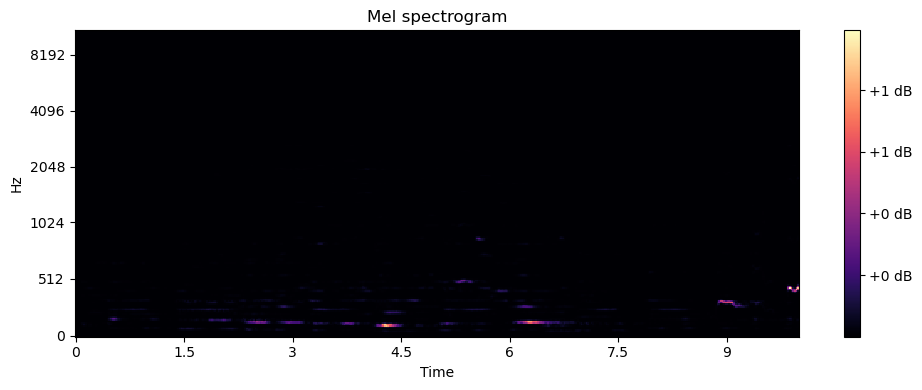

In [65]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [52]:
y, sr = librosa.load("mp3_full/" + classical_df.iloc[2]['mp3_path'], sr=22050, duration=10.0)
y = y / np.max(np.abs(y))  # normalize

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, hop_length=512, n_fft=2048)
S_dB = librosa.power_to_db(S, ref=np.max)

# Invert dB to power
S_power = librosa.db_to_power(S_dB)

# Invert mel spectrogram to audio
audio = librosa.feature.inverse.mel_to_audio(S_power, sr=sr, hop_length=512, n_iter=100)
Audio(audio, rate=22050)